In [1]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import os
import boto3
import random
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import StandardScaler
plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

warnings.filterwarnings('ignore')

In [2]:
os.environ["AUTH_TOKEN"]

'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPRE9SdWotcVYtcnNBbm9HM0loRmFJWlc3TndiQjJNWmE4UFBfMnZtcHpjIn0.eyJleHAiOjE3MDU4NDU4NDUsImlhdCI6MTcwNTI0MTA0NSwiYXV0aF90aW1lIjoxNzA1MjQxMDQ1LCJqdGkiOiI0Mjk5Njc1Yi0xZjRjLTQ4OGYtYjZlZC1mNWQ0NmUzYThjNWQiLCJpc3MiOiJodHRwczovL2tleWNsb2FrLnVhLmV6bS5sb2NhbC9yZWFsbXMvVUEiLCJhdWQiOiJ1YSIsInN1YiI6ImM0Nzc5NDkwLWQ5NDUtNGRhYi1hODI5LTdhYTViZDU5N2RkNCIsInR5cCI6IklEIiwiYXpwIjoidWEiLCJub25jZSI6Il92bHBsYUFuRlcwSXVoSnU1WldyVmJNd0FMNWNfWHBRR044dkk4aWJ4UE0iLCJzZXNzaW9uX3N0YXRlIjoiMWYyNmMxNGMtNTU2OC00NTExLWE3ODQtOTM4NmFjYjE0N2FhIiwiYXRfaGFzaCI6IjF3WTF3N214eV96ZHprNnR4bnJRSEEiLCJhY3IiOiIxIiwic2lkIjoiMWYyNmMxNGMtNTU2OC00NTExLWE3ODQtOTM4NmFjYjE0N2FhIiwidWlkIjoiNjAwMiIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwiZ2lkIjoiNTAwNSIsIm5hbWUiOiJkZW1vIEFuUFMiLCJncm91cHMiOlsidWEtZW5hYmxlZCIsIm9mZmxpbmVfYWNjZXNzIiwiYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtdWEiXSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZGVtbyIsImdpdmVuX25hbWUiOiJkZW1vIiwicG9zaXhfdXNlcm5hbWUiOiJkZW1vIiwiZmFtaWx5X25

In [3]:
os.environ["AWS_ACCESS_KEY_ID"]      = os.environ["AUTH_TOKEN"] 
os.environ["AWS_SECRET_ACCESS_KEY"]  = "s3"
os.environ["AWS_ENDPOINT_URL"]       = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'

config = {
    "MINIO_HOST_URL": "http://minio-service.ezdata-system.svc.cluster.local:30000",
    "MINIO_ACCESS_KEY": os.environ["AUTH_TOKEN"],
    "MINIO_SECRET_KEY": "s3",
    "KSERVE_MODEL_NAME": "body-performance",
    "NAMESPACE": open("/var/run/secrets/kubernetes.io/serviceaccount/namespace", "r").read(),
    "BUCKET": "body-performance",
    "FILE_PATH": "dataset",
}

if os.path.exists("temp"):
    os.system("rm -rf temp")
os.mkdir("temp")


In [4]:
def init_minio_client():
    client = boto3.client(
        service_name="s3",
        aws_access_key_id=config.get("MINIO_ACCESS_KEY"),
        aws_secret_access_key=config.get("MINIO_SECRET_KEY"),
        endpoint_url=config.get("MINIO_HOST_URL"),
        verify=False)
    return client

In [5]:
client = init_minio_client()
client.download_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/bodyPerfor_test.csv", Filename="./temp/bodyPerfor_test.csv")
client.download_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/bodyPerfor_class.csv", Filename="./temp/bodyPerfor_class.csv")
client.download_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/feature_importance.png", Filename="./temp/feature_importance.png")
client.download_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/permutation_importance.png", Filename="./temp/permutation_importance.png")
test  = pd.read_csv('./temp/bodyPerfor_test.csv')
label = pd.read_csv('./temp/bodyPerfor_class.csv')

In [6]:
DOMAIN_NAME = "svc.cluster.local"  # change this to your domain for external access
NAMESPACE = config.get("NAMESPACE")
DEPLOYMENT_NAME = config.get("KSERVE_MODEL_NAME")
MODEL_NAME = DEPLOYMENT_NAME
SVC = f'{DEPLOYMENT_NAME}-predictor-default.{NAMESPACE}.{DOMAIN_NAME}'
URL = f"https://{SVC}/v2/models/{MODEL_NAME}/infer"


# Data Preprocessing

In [7]:
xtest = test.copy()

test_temp = pd.get_dummies(xtest['gender'], drop_first=True)
test_temp = pd.concat([xtest,test_temp], axis=1)
test_temp['gender'] = test_temp['M']
test_temp.drop(columns=['M'], inplace=True)
test_temp.head(5)

id  age  gender  height  weight  body_fat  diastolic  systolic  grip_force  \
0  11   42       1   169.2    65.4      19.3       63.0     110.0        43.5   
1  22   59       0   155.9    62.7      30.2       76.0     143.0        36.8   
2  30   50       0   159.8    57.1      24.4       63.0     103.0        30.8   
3  49   28       1   180.1    82.1      15.0       83.0     147.0        52.6   
4  88   41       0   158.1    51.0      21.7       86.0     127.0        23.1   

   sit_bend_forward  sit_ups  broad_jump  
0              16.0     68.0         211  
1              29.1     25.0         122  
2              24.4     30.0         143  
3              18.8     55.0         247  
4              28.6     46.0         165

In [8]:
features = [ 'age', 'gender', 'height', 'weight', 'body_fat', 'diastolic', 'systolic', 'grip_force', 'sit_bend_forward', 'sit_ups', 'broad_jump']
xtest  = test_temp[features].copy()

scale = StandardScaler().fit(xtest)
xtest_scale = scale.transform(xtest)

In [9]:
id = random.choice(range(0,xtest_scale.shape[0]))
id

1813

In [10]:
xtest[xtest.index == id]

age  gender  height  weight  body_fat  diastolic  systolic  grip_force  \
1813   22       1   185.3    73.7      12.6       93.0     148.0        42.0   

      sit_bend_forward  sit_ups  broad_jump  
1813               8.6     55.0         230

In [11]:
inference_request = {
    "inputs" : [{
        "name" : "body-performance",
        "datatype": "FP32",
        "shape": [1, xtest_scale.shape[1]],
        # Example of non-fraudulent Transaction Dtls
        # "data": [list(item) for item in X.values][14],
        # Example of a fraudulent request
        "data": [list(item) for item in xtest_scale][id],
    }]
}

print("data:", inference_request)


data: {'inputs': [{'name': 'body-performance', 'datatype': 'FP32', 'shape': [1, 11], 'data': [-1.08495591896265, 0.7733639703593451, 1.9355678175424822, 0.5329524082133764, -1.458560422974089, 1.3410380505157113, 1.2160644600398276, 0.4838614556954663, -0.8319441518109794, 1.081161787100422, 1.0273695929326994]}]}


In [12]:
session = requests.Session()
message = {"message":"", "value":""}

headers = {"Authorization": f"Bearer {auth_token}"}
response = requests.post(URL, json=inference_request, headers=headers, verify=False)

In [13]:
resp = json.loads(response.content).get('outputs')[0].get('data')
re = pd.Series(resp)
pred = re.map({0:"좋음",1:"보통",2:"나쁨",3:"위험"})[0]


In [14]:
print(URL)
print()

actual = label[label.index==id]['class'].map({"A":"좋음","B":"보통","C":"나쁨","D":"위험"}).item()
print("%16s  %12s   %15s"%("Feature","Source","Scaled_Data"))
for i, col in enumerate(xtest.columns):
    print("%16s  %12.3f   %15.8f"%(col,xtest[xtest.index == id][col].item(),inference_request['inputs'][0]['data'][i]))
print("==================================")
print('Predict: ',pred, ', Actual: ', actual)
print("==================================")

https://body-performance-predictor-default.demo.svc.cluster.local/v2/models/body-performance/infer

         Feature        Source       Scaled_Data
             age        22.000       -1.08495592
          gender         1.000        0.77336397
          height       185.300        1.93556782
          weight        73.700        0.53295241
        body_fat        12.600       -1.45856042
       diastolic        93.000        1.34103805
        systolic       148.000        1.21606446
      grip_force        42.000        0.48386146
sit_bend_forward         8.600       -0.83194415
         sit_ups        55.000        1.08116179
      broad_jump       230.000        1.02736959
Predict:  나쁨 , Actual:  나쁨


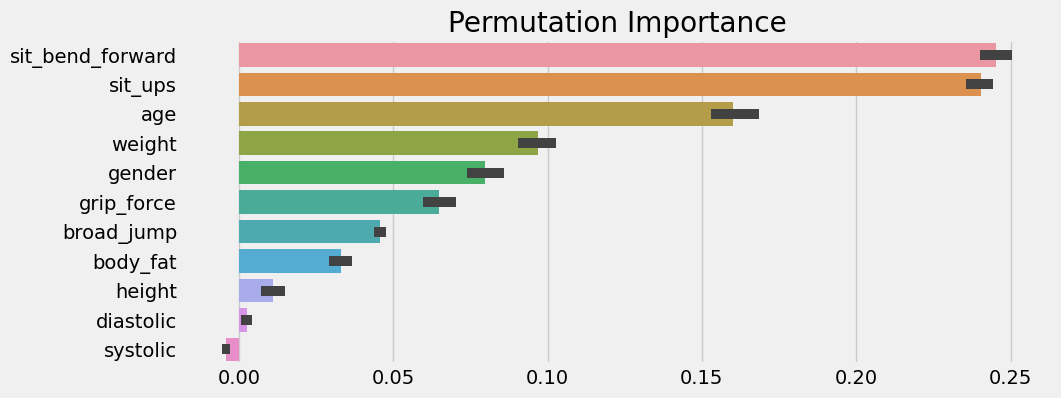

In [15]:
img = Image.open("./temp/permutation_importance.png").convert('RGB')
img.save("./temp/permutation_importance.png")
img.show()